In [1]:
import pandas as pd
from tech_core.feature_pipeline import FeaturesPipeline

path_to_data = '../data/'

Loading features: 0it [00:00, ?it/s]


cmf_dim: 126, asset_dim: 5, num_assets: 488
Sharpe Ratio for the epoch: 3.2943
Average Weights:



,Weight
Cash,0.262539
BKNG,0.111186
GRMN,0.026983
IRM,0.024752
PTC,0.023254
...,...
TGT,0.000157
LYB,0.000155
CZR,0.000134
ALB,0.000127


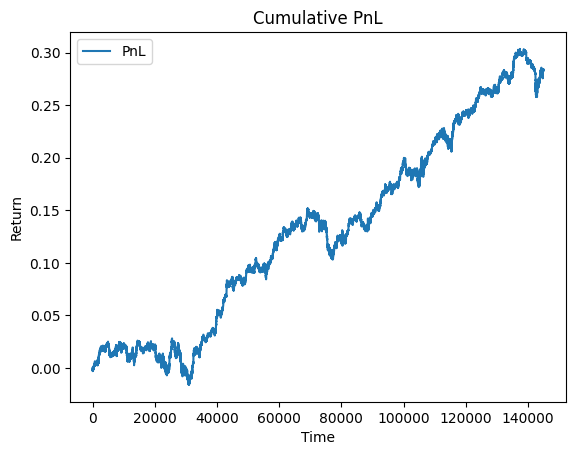

Sharpe Ratio for the epoch: 4.9815
Average Weights:



,Weight
Cash,0.289013
BKNG,0.115383
GRMN,0.027990
IRM,0.024925
IBM,0.023545
...,...
TGT,0.000137
LYB,0.000133
CZR,0.000116
ALB,0.000111


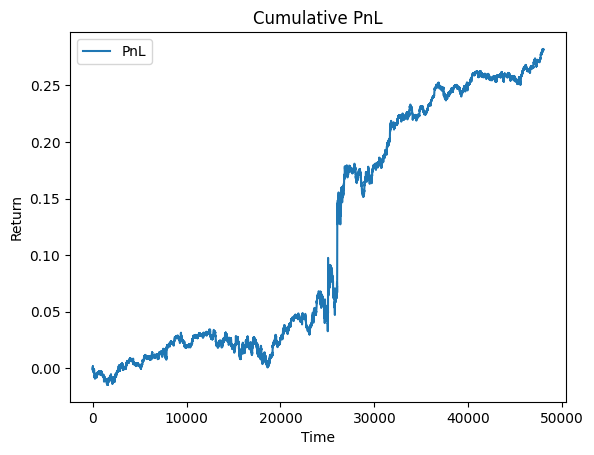

Sharpe Ratio for the epoch: 9.5469
Average Weights:



,Weight
Cash,0.844824
BKNG,0.034746
FICO,0.017641
NVR,0.016001
MPWR,0.012474
...,...
LYB,0.000008
LKQ,0.000008
ALB,0.000007
CZR,0.000007


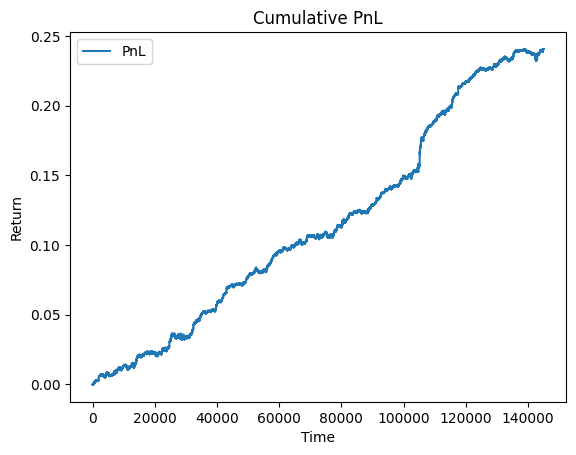

Sharpe Ratio for the epoch: 10.7888
Average Weights:



,Weight
Cash,0.848433
BKNG,0.035491
FICO,0.017269
NVR,0.016640
MPWR,0.012572
...,...
LYB,0.000007
LKQ,0.000007
ALB,0.000006
CZR,0.000006


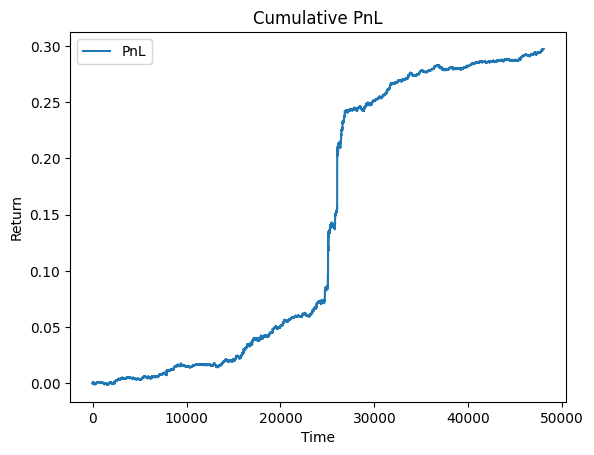

In [ ]:
from tech_core.losses import StreamingSharpeLoss
from tech_core.nn_builder import SimplePortfolioAllocator, DeepPortfolioAllocator
import torch
from tqdm import tqdm

split_dates = [
    pd.Timestamp("2025-01-01")
]
split_names = ['train', 'test']

pipeline = FeaturesPipeline(path_to_data, padding=35, chunk_size=1000,
                        split_dates=split_dates,
                        split_names=split_names)

cmf_dim = asset_dim = num_assets = None
for common_feats, asset_feats, fut_ret, _, _ in tqdm(pipeline.iterate('train'), desc="Loading features"):
    cmf_dim = common_feats.shape[1]
    asset_dim = asset_feats.shape[2]
    num_assets = asset_feats.shape[1]
    break

print(f"cmf_dim: {cmf_dim}, asset_dim: {asset_dim}, num_assets: {num_assets}")

model = SimplePortfolioAllocator(
    cmf_dim=cmf_dim,
    asset_dim=asset_dim,
    num_assets=num_assets,
    hidden_cmf=64,
    hidden_asset=32,
    head_hidden=16
)

# Big NN
# Sharpe Ratio (MSE-guided) for the epoch: 0.0106
# Total MSE loss for the epoch: 0.0000007199
# Pnl : 0.2

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 100 # Количество эпох обучения
for epoch in range(num_epochs):
    loss_fn = StreamingSharpeLoss(
        asset_names=pipeline.reader.asset_names + ['Cash'],  # Добавляем Cash в список активов
    )
    loss_fn.reset()
    pipeline.reset()
    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps,  dtype=torch.float32).to(device)       # (T, n_assets)
 
        if len(common_feats) != 1000:
            continue

        optimizer.zero_grad()

        # Вычисляем веса
        weights = model(common_feats, asset_feats)  # (T, n_assets)
        # Обновляем метрику
        loss_value = loss_fn.forward(
            weights=weights,
            returns=fut_ret,
            min_prices=min_prices,
            market_caps=market_caps
        )
        loss_value.backward()

        optimizer.step()

    if (epoch + 1) % 10 == 0:
        loss_fn.plot_whole_epoch_loss()  # Выводим Sharpe Ratio за эпоху
    loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps,  dtype=torch.float32).to(device)

        if len(common_feats) != 1000:
            continue

        weights = model(common_feats, asset_feats)
        loss_fn.forward(weights=weights, returns=fut_ret, min_prices=min_prices, market_caps=market_caps)

    if (epoch + 1) % 10 == 0:
        loss_fn.plot_whole_epoch_loss()
    loss_fn.reset()